# <center><font color='OrangeRed'>Маркетинговая аналитика Яндекс.Афиша</font></center>

Мною будет проведен анализ маркетинговых показателей Яндекс.Афиши за период с июня 2017 по конец мая 2018 года.

Главная **цель** анализа - оптимизировать затраты отделы маркетинга (отказаться от невыгодных источников трафика и перераспределить бюджет).

У меня есть следующие *исходные данные*:
 - лог сервера с данными о посещениях сайта Яндекс.Афиши;
 - выгрузка всех заказов за этот период;
 - статистика рекламных расходов.
 
Иследовательский анализ будет построен из следующих *этапов*:

1. [Обзор данных из доступных источников](#obzor)
2. [Построение отчётов и расчёт метрик](#metricks)
    * [Продуктовые метрики](#products)
    * [Метрики электронной коммерции](#electro)
    * [Маркетинговые метрики](#market)
    
3. [Рекомендации отделу маркетинга](#recomend)

Результатом данного анализа будут являться рекомендации маркетологам по рациональному и целевому использованию бюджетных средств.

В моем распоряжении три датасета:
- visits_log.csv - лог сервера с информацией о посещениях сайта,
- orders_log.csv — информацию о заказах, 
- costs.csv — информацию о расходах на маркетинг.

**visits_log.csv**

- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

**orders_log.csv**

- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

**costs.csv**

- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

# <a id="obzor"></a><font style="background-color: Cyan; color=black">1. Обзор данных из доступных источников</font> #

In [1]:
import random
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math

In [2]:
colors=['green', 'hotpink', 'orangered', 'deepskyblue', 
        'cyan', 'purple', 'gold', 'chocolate', 'dimgrey', 'darkviolet',
       'navy', 'lime', 'coral', 'black']

In [3]:
def check_df(df):
    display(df.head(10))
    print(f'Количество дубликатов в датафрейме: {df.duplicated().sum()}')
    print()
    print('Количество пропущенных значений:')
    display(df.isna().sum())
    print()
    print('Общая информация о датафрейме:')
    display(df.info()) 

<font color='blue'>Лог сервера с данными о посещениях сайта Яндекс.Афиши</font>

In [4]:
visits_log = pd.read_csv('/datasets/visits_log.csv')
display(visits_log.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
check_df(visits_log)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Количество дубликатов в датафрейме: 0

Количество пропущенных значений:


Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

Лог сервера с данными о посещениях сайта содержит следующую информацию:
 - **359 400** строк,
 - **5** столбцов,
 - тип данных у стобцов Device, End Ts и Start Ts -  *object*
 - тип данных у столбцов Source Id, Uid - *целочисленные* (int и uint64 соответственно)
 - пропусков и дубликатов не обнаружено

Так как столбцы End Ts (дата и время окончания сессии) и Start Ts (дата и время начала сессии) - это столбцы с датой и временем, следует привести их к типу datetime64.

In [6]:
visits_log.columns = ['device','end_ts','source_id','start_ts','uid'] 

In [7]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])

In [8]:
print('Количество уникальных значений в столбце Device:')
display(visits_log['device'].value_counts()) 

Количество уникальных значений в столбце Device:


desktop    262567
touch       96833
Name: device, dtype: int64

2 варианта устройств пользователей - *touch* и *desktop*

In [9]:
visits_log['source_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

Идентификаторов рекламного источника указано **9** вариантов: от 1 до 10, за исключением *8*.

<font color='blue'>Выгрузка всех заказов</font>

In [10]:
orders_log = pd.read_csv('/datasets/orders_log.csv')
display(orders_log.head())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
check_df(orders_log)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Количество дубликатов в датафрейме: 0

Количество пропущенных значений:


Buy Ts     0
Revenue    0
Uid        0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

Выгрузка всех заказов содержит следующую информацию:
 - **50 415** строк,
 - **3** столбца,
 - тип данных у стобца Buy Ts -  *object*
 - тип данных у столбцов Revenue, uid - *числовые* (float и uint64 соответственно)
 - пропусков и дубликатов не обнаружено

Так как столбец Buy Ts (дата и время заказа) - это столбец с датой и временем, следует привести его к типу datetime64.

In [12]:
orders_log.columns = ['buy_ts', 'revenue', 'uid']

In [13]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])

In [14]:
orders_log['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

В данных по выручке за указанный период наблюдается большой разброс: от *0 до 2 633,28*. 

Среднее - чуть меньше **5** 

Медиана - **2.5** 

Разброс может быть связан с очень дифференцированным продуктом, представленным на сервисе(даже в рамках одной услуги по цены могут отличаться в зависимости от места, которое покупает пользователь. Также цены отличаются по разным услугам).

<font color='blue'>Статистика рекламных расходов</font>

In [15]:
costs = pd.read_csv('/datasets/costs.csv')
display(costs.head())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
check_df(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Количество дубликатов в датафрейме: 0

Количество пропущенных значений:


source_id    0
dt           0
costs        0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Статистика рекламных расходов содержит следующую информацию:
 - **2 542** строки,
 - **3** столбца,
 - тип данных у стобца dt -  *object*
 - тип данных у столбцов source_id, costs - *числовые* (float и uint64 соответственно)
 - пропусков и дубликатов не обнаружено

Так как столбец dt (дата) - это столбец с датой и временем, следует привести его к типу datetime64.

In [17]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

В данном датафрейме присутствуют данные о затратах на рекламу только по *7* источникам. Отсутствуют данные о затратах по *6 и 7* источникам.

In [18]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

В данных по затратам на рекламу за указанный период наблюдается большой разброс: от *0.54 до 1 788,28*. 

Среднее - чуть меньше **130** 

Медиана - чуть более **77** 

Разброс может быть связан с различными методами рекламы. 
У меня нет информации, какой именно метод рекламы применялся в случаях 6 и 7, отсюда сложно подставить конкретное значение. Предположу, что это были незатратные методы и заменю значения на **0**

<font color='Red'>Вывод:</font> мною были изучены представленые данные. Основной момент, который требует доработки - восстановить тип данных, применяемый к столбцам с датой и временем. 
К методам 6 и 7 по рекламе очень сложно подобрать необходимое значение, поэтому мною будет подставлено значение 0, так как я предполагаю, что эти методы были без затрат.

# <a id='metricks'></a><font style="background-color: Cyan; color=black">2. Построение отчётов и расчёт метрик</font> #

<a id='products'></a><font color='blue'>Продуктовые метрики</font>

<font color='green'>DAU, WAU, MAU</font>

В таблице лог сервера с данными о посещениях сайта Яндекс.Афиши (visits_log) содержатся данные о пользовательской активности. Рассчитаю показатели **DAU** (уникальные пользователи в день), **WAU** (уникальные пользователи в неделю) и **MAU** (уникальные пользователи в месяц) и **sticky factor** по отношению к недельной и к месячной аудитории. Для расчетов буду использовать отдельные столбцы времени начала сессии: год, месяц, неделя и полная дата.

In [19]:
visits_log['month'] = visits_log['start_ts'].dt.month
visits_log['date'] = visits_log['start_ts'].dt.date
visits_log['day_of_week'] = visits_log['start_ts'].dt.week
visits_log['year'] = visits_log['start_ts'].dt.year
visits_log.head()

,device,end_ts,source_id,start_ts,uid,month,date,day_of_week,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,2017-12-20,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,2018-02-19,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,2017-07-01,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,2018-05-20,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,12,2017-12-27,52,2017


In [20]:
dau_mean = visits_log.groupby('date').agg({'uid': 'nunique'}).mean()
wau_mean = visits_log.groupby(['year', 'day_of_week']).agg({'uid': 'nunique'}).mean()
mau_mean = visits_log.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
sticky_wau = (dau_mean / wau_mean) * 100
sticky_mau = (dau_mean / mau_mean) * 100
print(f'Средний DAU за весь период = {int(dau_mean)}')
print(f'Средний WAU за весь период = {int(wau_mean)}')
print(f'Средний MAU за весь период = {int(mau_mean)}')
print('Sticky factor по отношению к недельной аудитории = {:.2f}%'.format(sticky_wau.mean()))
print('Sticky factor по отношению к месячной аудитории = {:.2f}%'.format(sticky_mau.mean()))

Средний DAU за весь период = 907
Средний WAU за весь период = 5716
Средний MAU за весь период = 23228
Sticky factor по отношению к недельной аудитории = 15.88%
Sticky factor по отношению к месячной аудитории = 3.91%


- Посещений в день -  **907**;
- Посещений в неделю - **5 716**;
- Посещений в месяц - **23 228**

Вовлечённость недельной аудитории - **15,88%**.
Вовлечённость месячной аудитории - **3,91%**.

In [21]:
visits_log['visit_month_mau'] = visits_log['date'].astype('datetime64[M]')
visits_log['visit_week_wau'] = visits_log['date'].astype('datetime64[W]')

In [22]:
dau = visits_log.groupby('date').agg({'uid': 'nunique'}).reset_index()
wau = visits_log.groupby(['visit_week_wau']).agg({'uid': 'nunique'}).reset_index()
mau = visits_log.groupby(['visit_month_mau']).agg({'uid': 'nunique'}).reset_index()

In [23]:
def metric_plot(metric, date, period):
    display(metric['uid'].describe().round(2))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.plot(metric[date],metric['uid'],color=random.choice(colors))
    ax1.set_xlabel(period)
    ax1.set_ylabel('Количество уникальных пользователей')
    ax1.set_title(f'Динамика активных пользователей в {period}')
    ax1.grid()
    sns.distplot(metric['uid'], ax=ax2, color=random.choice(colors))
    ax2.set_xlabel('Количествово уникальных пользователей')
    ax2.grid()
    print('Максимальное и минимальное количество пользователей в период')
    display(metric[(metric['uid'] == metric['uid'].min()) | (metric['uid'] == metric['uid'].max())])

count     364.00
mean      907.99
std       370.51
min         1.00
25%       594.00
50%       921.00
75%      1173.00
max      3319.00
Name: uid, dtype: float64

Максимальное и минимальное количество пользователей в период


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,date,uid
176,2017-11-24,3319
303,2018-03-31,1


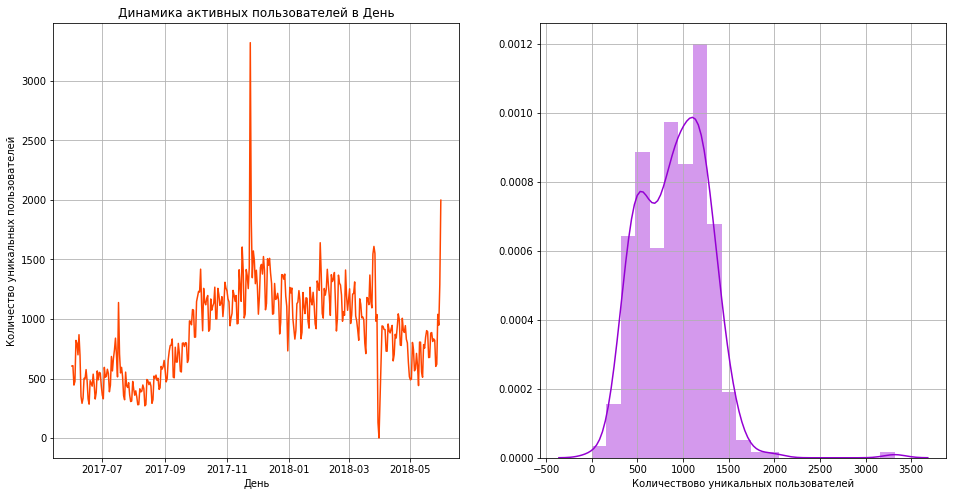

In [24]:
metric_plot(dau, 'date', 'День')

- По медианному значению -  в день посещает сервис **921** пользователей
- Количество посещений неуклонно растетс августа, достигая максимума к началу декабря
- С февраля по май в среднем идет снижение посещений
- Максимальное кол-во посещений **3319** было 2017-11-24 (возможно, открылась продажа на событие в новогодние праздники)
- Минимальное кол-во посещений **1** было 2018-03-31 (Подозрительные данные, но вполне может быть, если сервис в этот день не работал, например)

count       53.00
mean      5724.42
std       2096.12
min       1997.00
25%       4056.00
50%       5894.00
75%       7441.00
max      10716.00
Name: uid, dtype: float64

Максимальное и минимальное количество пользователей в период


,visit_week_wau,uid
25,2017-11-23,10716
52,2018-05-31,1997


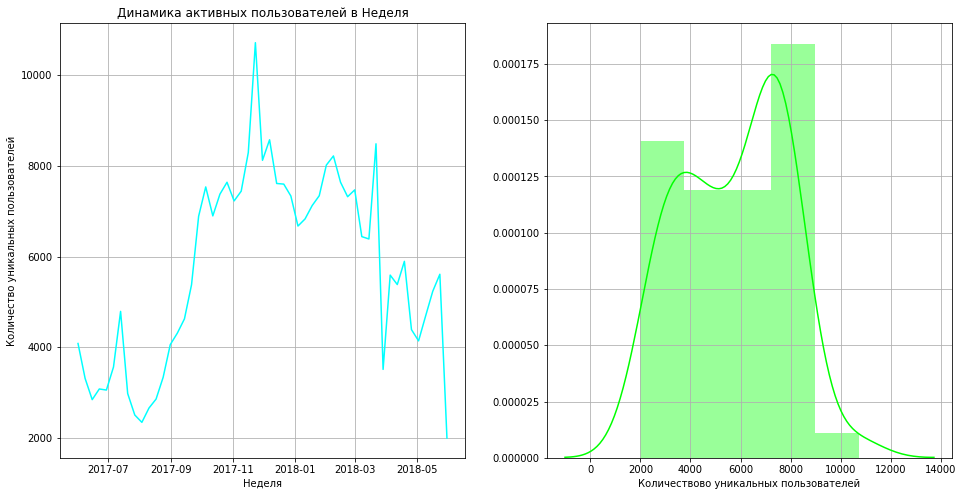

In [25]:
metric_plot(wau,'visit_week_wau','Неделя')

По медианному значению -  посещает сервис **5 894** пользователей в неделю.
Динамика аналогична для описания активных пользователей по дням

count       12.00
mean     23228.42
std       7546.38
min      11631.00
25%      17777.00
50%      24240.50
75%      28984.75
max      32797.00
Name: uid, dtype: float64

Максимальное и минимальное количество пользователей в период


,visit_month_mau,uid
2,2017-08-01,11631
5,2017-11-01,32797


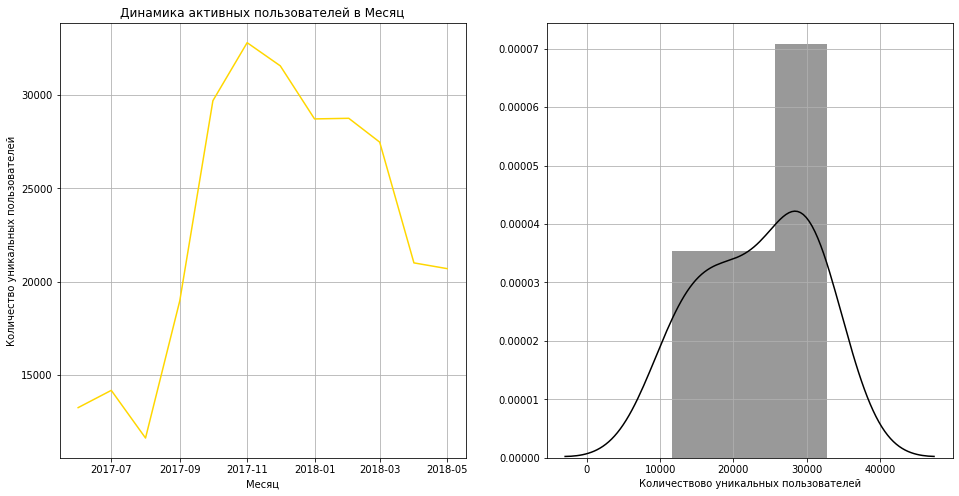

In [26]:
metric_plot(mau,'visit_month_mau','Месяц')

- По медианному значению - в месяц посещает сервис **24 240** пользователей
- Динамика схожа с динамиками по неделям и дням: резкий рост в августе и снижение с декабря
- Во всех случаях распределения имеют 2 вершины. Это может быть связано с тем, что, например, начали продавать билеты, на ранее недоступные мероприятия или открылись новые услуги (билеты в новом городе)

<font color='green'>Среднее время сессии</font>

In [27]:
visits_log['lifetime'] = visits_log['end_ts'] - visits_log['start_ts']
visits_log['lifetime'] = visits_log['lifetime'].dt.seconds

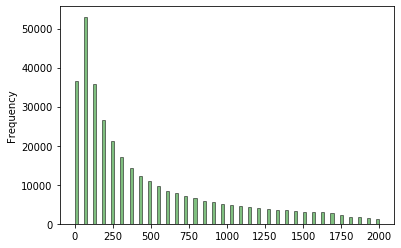

In [28]:
hist = visits_log['lifetime'].plot(kind = 'hist',
                                   bins = 100,
                                   range = (0,2000),
                                   alpha=0.5,
                                   ec='black',
                                   color=random.choice(colors)
                                  )
plt.show()

Видно , что это распределение не нормальное. Поэтому посчитать здесь среднее или медиану не имеет смысла. Считаю моду.

In [29]:
mode = visits_log['lifetime'].mode()

Средняя продолжительность сессии **60** секунд.

<font color='green'>Когортный анализ и Retention Rate</font>

In [30]:
first_date = visits_log.groupby('uid')['start_ts'].min()
first_date.name = 'first_date'
visits_log = visits_log.merge(first_date, on = 'uid')

In [31]:
visits_log['first_month'] = visits_log['first_date'].astype('datetime64[M]')

In [32]:
visits_log['cohort_lifetime'] = (visits_log['start_ts']-visits_log['first_date'])/np.timedelta64(1,'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')

In [33]:
visits_log.head()

,device,end_ts,source_id,start_ts,uid,month,date,day_of_week,year,visit_month_mau,visit_week_wau,lifetime,first_date,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,2017-12-20,51,2017,2017-12-01,2017-12-14,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,2018-02-19,8,2018,2018-02-01,2018-02-15,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,2017-07-01,26,2017,2017-07-01,2017-06-29,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,2018-05-20,20,2018,2018-05-01,2018-05-17,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,3,2018-03-09,10,2018,2018-03-01,2018-03-08,1680,2018-03-09 20:05:00,2018-03-01,0


In [34]:
cohorts = (visits_log
           .groupby(['first_month', 'cohort_lifetime'])
           .agg({'uid': 'nunique'})
           .reset_index())

cohort_user = cohorts[cohorts['cohort_lifetime']==0][['first_month','uid']]
cohort_user = cohort_user.rename(columns = {'uid': 'cohort_user'})

cohorts = cohorts.merge(cohort_user, on = 'first_month')

cohorts['retention'] = (cohorts['uid'] / cohorts['cohort_user'])

cohorts['first_month'] = cohorts['first_month'].astype('str') 
retention_pivot = (cohorts
                   .pivot_table(index='first_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum'))

retention_pivot.round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2017-06-01,1.0,0.07,0.05,0.06,0.07,0.07,0.06,0.06,0.06,0.05,0.04,0.04,0.01
2017-07-01,1.0,0.06,0.05,0.05,0.06,0.05,0.04,0.05,0.04,0.03,0.02,0.01,
2017-08-01,1.0,0.07,0.06,0.06,0.05,0.04,0.04,0.03,0.03,0.02,0,,
2017-09-01,1.0,0.08,0.07,0.05,0.04,0.04,0.03,0.03,0.02,0,,,
2017-10-01,1.0,0.07,0.05,0.04,0.04,0.03,0.02,0.02,0,,,,
2017-11-01,1.0,0.07,0.05,0.04,0.03,0.02,0.02,0,,,,,
2017-12-01,1.0,0.05,0.04,0.03,0.02,0.02,0,,,,,,
2018-01-01,1.0,0.05,0.04,0.03,0.02,0,,,,,,,
2018-02-01,1.0,0.05,0.03,0.02,0,,,,,,,,


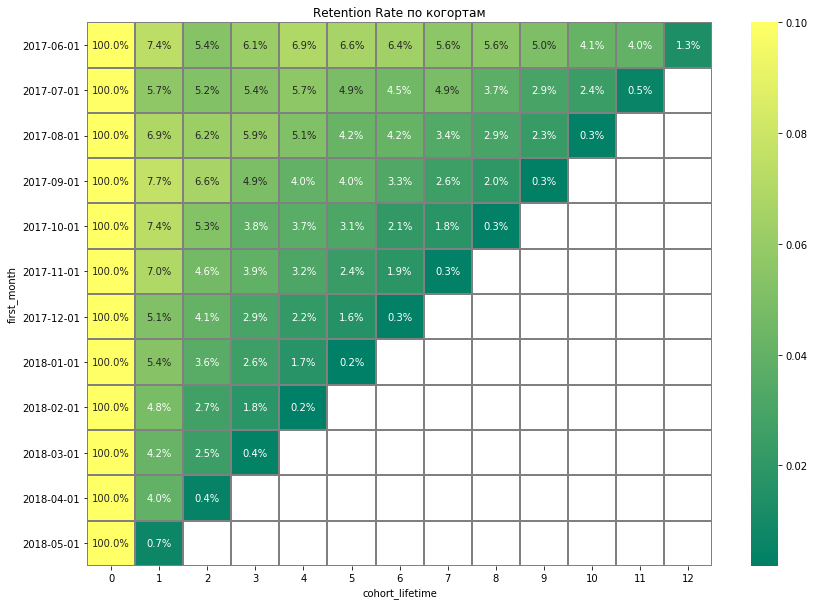

In [35]:
plt.figure(figsize=(14,10))
sns.heatmap(retention_pivot,
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='gray',
            vmax = 0.1,
            cmap = 'summer')

plt.title('Retention Rate по когортам')
plt.show()

In [36]:
print('В среднем около {:.1%} пользователей возвращается на сайт на следующий месяц после первого посещения.'
      .format(retention_pivot[1].mean(),2))

В среднем около 5.5% пользователей возвращается на сайт на следующий месяц после первого посещения.


Retention rate на уровне **5,5%** - очень низко

По графикам видно, что есть спад спроса в летние месяцы (DAU,WAU,MAU). 

При средней продолжительности сессии в **60 секунд** коэффициент удержания очень низкий. 

В августе 2017 года наблюдалось снижение пользовательской активности. Это может быть связано с какими-то иными факторами, не имеющими отношение к приверженности пользователей. В сентябре наблюдался рост показателей для июньской и августовской когорт; но пользователи из июльской когорты сократили посещение. В октябре видим рост по всем когортам, кроме августовской. 
Так, по всем когортам наблюдается спад активности на второй месяц использования сайта, что должно быть учтено в маркетинговой компании Яндекс.Афиши.
На тепловой карте видно, что в 2018 году (в последних когортах) отток пользователей массовый. Судя по всему пользователи приходят, пользуются услугой(или не пользуются) и уходят, не возвращаясь. 

<a id='electro'></a><font color='blue'>Метрики электронной коммерции</font>

In [37]:
first_visit = visits_log.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid','first_visit']
first_visit['first_visit_dt'] = first_visit['first_visit'].dt.date
first_visit['first_visit_month'] = first_visit['first_visit'].astype('datetime64[M]')
first_visit.head()

,uid,first_visit,first_visit_dt,first_visit_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01


In [38]:
first_orders = orders_log.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid','first_orders_dt']
first_orders['first_orders_month'] = first_orders['first_orders_dt'].astype('datetime64[M]')
first_orders['first_orders_day'] = first_orders['first_orders_dt'].astype('datetime64[D]')

first_orders.head()

,uid,first_orders_dt,first_orders_month,first_orders_day
0,313578113262317,2018-01-03 21:51:00,2018-01-01,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,2017-10-01,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2018-01-01,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-01,2017-11-24


In [39]:
byuers = pd.merge(first_visit,first_orders, on = 'uid')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24


<font color='green'>Среднее время, прошедшее от первого визита до покупки</font>

In [40]:
byuers['time_per_orders'] = ((byuers['first_orders_dt'] - byuers['first_visit'])/np.timedelta64(1,'D')).astype('int')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0


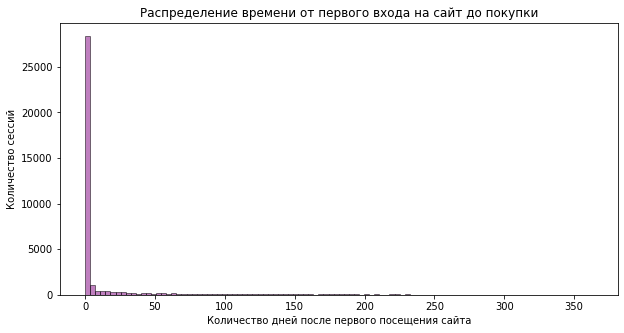

In [41]:
(byuers['time_per_orders']
 .plot(kind = 'hist',
       bins = 100,
       figsize = (10,5),
       alpha=0.5,
       ec='black',
       color = random.choice(colors))
 .set(title = 'Распределение времени от первого входа на сайт до покупки',
      xlabel = 'Количество дней после первого посещения сайта',
      ylabel = 'Количество сессий'))
plt.show()

На гистограмме заметно, что длина сессий распределена неравномерно. Это отразится на разнице между средним значением, модальным значением и медианой.

Гистограмма показывает не нормальное распределение. Виден пик значений в нуле.

In [42]:
time_per_orders_mean = byuers['time_per_orders'].mean()
print(f'Среднее время с момента входа до совершения покупки - {time_per_orders_mean.round(2)} дней')

Среднее время с момента входа до совершения покупки - 16.73 дней


Видно, что среднее не показывает реальную ситуацию. Посчитаем медиану

In [43]:
time_per_orders_median = byuers['time_per_orders'].median()
print(f'Медианное время с момента входа до совершения покупки - {time_per_orders_median.round(2)} дней')

Медианное время с момента входа до совершения покупки - 0.0 дней


В среднем время от первого визита до покупки 16 дней. Но на гистограмме видно, что, как правило, время сесии близко к нулю. Это значит, что покупка в большинстве случаев происходит сразу при посещении. Это же показывает и медиана.

<font color='green'>Количество покупок в среднем за полгода</font>

In [44]:
orders_log['orders_month'] = orders_log['buy_ts'].astype('datetime64[M]')
cohort_count = (pd.merge(byuers,orders_log, how = 'inner', on = 'uid')
          .groupby(['first_orders_month','orders_month'])
          .agg({'revenue':'count'})
          .reset_index())
cohort_count.rename(columns = {'revenue':'revenue_count'}, inplace = True)
cohort_count.head()

,first_orders_month,orders_month,revenue_count
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [45]:
cohort_size = byuers.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
cohort_size.rename(columns = {'uid':'n_buyers'}, inplace = True)
cohort_size

,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [46]:
cohort_count['age_cohort'] = (((cohort_count['orders_month']-cohort_count['first_orders_month'])/np.timedelta64(1,'M'))
                              .round().astype('int'))
cohort_count.head()

,first_orders_month,orders_month,revenue_count,age_cohort
0,2017-06-01,2017-06-01,2354,0
1,2017-06-01,2017-07-01,177,1
2,2017-06-01,2017-08-01,174,2
3,2017-06-01,2017-09-01,226,3
4,2017-06-01,2017-10-01,292,4


In [47]:
cohort_revenue_count = pd.merge(cohort_size,cohort_count,on = 'first_orders_month')
cohort_revenue_count['amount_buy_per_buyers'] = (cohort_revenue_count['revenue_count']/cohort_revenue_count['n_buyers'])
cohort_revenue_count

,first_orders_month,n_buyers,orders_month,revenue_count,age_cohort,amount_buy_per_buyers
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2,0.049816
75,2018-04-01,2276,2018-04-01,2495,0,1.096221
76,2018-04-01,2276,2018-05-01,195,1,0.085677
77,2018-05-01,2988,2018-05-01,3249,0,1.087349


In [48]:
amount_buy_per_buyers = (cohort_revenue_count
                        .pivot_table(index = 'first_orders_month',
                                    columns = 'age_cohort',
                                    values = 'amount_buy_per_buyers',
                                    aggfunc = 'sum')
                        .cumsum(axis=1))
amount_buy_per_buyers.round(2).fillna('')

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


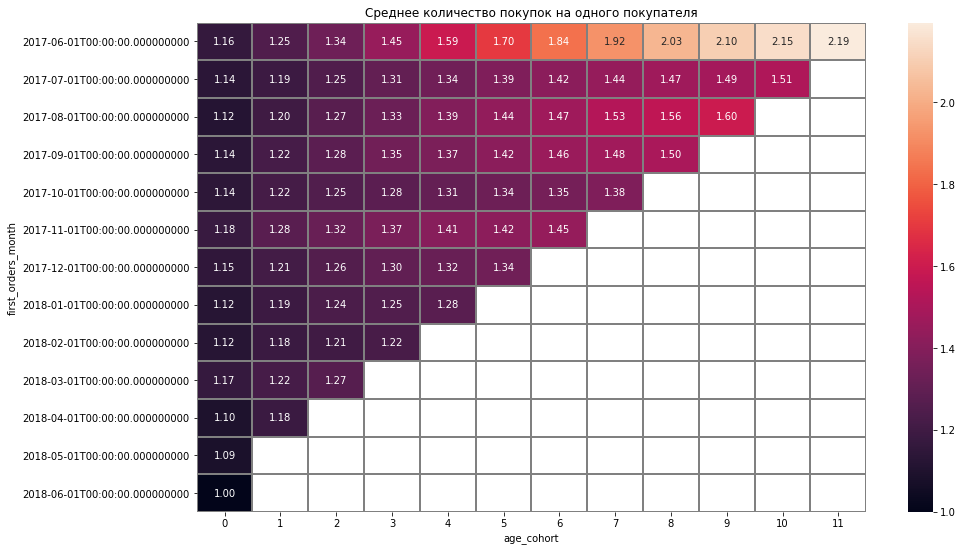

In [49]:
plt.figure(figsize=(15, 9))
plt.title('Cреднее количество покупок на одного покупателя')
sns.heatmap(amount_buy_per_buyers,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray'
           ) 
plt.show()

In [50]:
print(f'Среднее количество покупок за полгода на одного покупателя - {round(amount_buy_per_buyers[5].mean(),2)}')

Среднее количество покупок за полгода на одного покупателя - 1.43


<font color='green'>Средний чек</font>

In [51]:
cohort_sum = (pd.merge(orders_log,byuers, how = 'inner', on = 'uid')
          .groupby(['first_orders_month','orders_month'])
          .agg({'revenue':'sum'})
          .reset_index())
cohort_sum.rename(columns = {'revenue':'revenue_sum'}, inplace = True)
cohort_mean_chek = pd.merge(cohort_count,cohort_sum, on = ['first_orders_month','orders_month'])
cohort_mean_chek['sum_per_count'] = cohort_mean_chek['revenue_sum']/cohort_mean_chek['revenue_count']
cohort_mean_chek.head()

,first_orders_month,orders_month,revenue_count,age_cohort,revenue_sum,sum_per_count
0,2017-06-01,2017-06-01,2354,0,9557.49,4.060106
1,2017-06-01,2017-07-01,177,1,981.82,5.547006
2,2017-06-01,2017-08-01,174,2,885.34,5.088161
3,2017-06-01,2017-09-01,226,3,1931.30,8.545575
4,2017-06-01,2017-10-01,292,4,2068.58,7.084178


In [52]:
cohort_mean_chek['first_orders_month'] = cohort_mean_chek['first_orders_month'].astype('str')
mean_chek =(cohort_mean_chek
            .pivot_table(index='first_orders_month',
                        columns = 'age_cohort',
                        values = 'sum_per_count',
                        aggfunc = 'sum'))
            
mean_chek.round(2).fillna('')

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


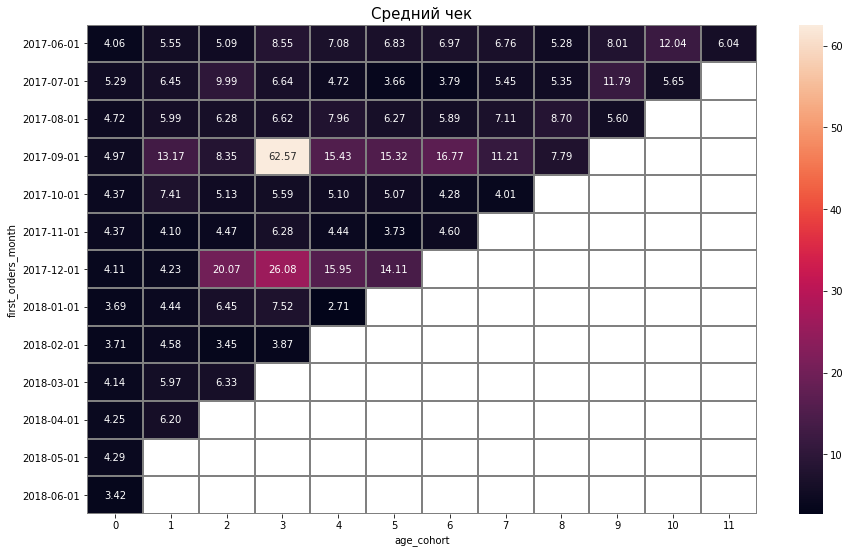

In [53]:
plt.figure(figsize=(15, 9))
plt.title('Cредний чек',fontsize = 15)
sns.heatmap(mean_chek,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray'
           ) 
plt.show()

От всех явно отличаются сентябрьская и декабрьская когорты. В сентябрьской средний чек в декабре достиг пика. Во всех остальных когортах средний чек невысокий. Опять же, когорты 2018 года с низким показателем (максимум в январской когорте 7,5).

<font color='green'>LTV</font>

In [54]:
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0


Количество уникальных пользователей по месяцу первой покупки

In [55]:
cohort_size = byuers.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
cohort_size.rename(columns = {'uid':'n_buyers'}, inplace = True)
cohort_size

,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [56]:
cohort_ltv = pd.merge(cohort_sum,cohort_size,on = 'first_orders_month')
cohort_ltv

,first_orders_month,orders_month,revenue_sum,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533
75,2018-04-01,2018-04-01,10600.69,2276
76,2018-04-01,2018-05-01,1209.92,2276
77,2018-05-01,2018-05-01,13925.76,2988


In [57]:
cohort_ltv['rev_per_buyers'] = cohort_ltv['revenue_sum']/cohort_ltv['n_buyers']
cohort_ltv['age_cohort'] = ((cohort_ltv['orders_month']-cohort_ltv['first_orders_month'])/np.timedelta64(1,'M')).round().astype('int')
cohort_ltv.head()

,first_orders_month,orders_month,revenue_sum,n_buyers,rev_per_buyers,age_cohort
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4


In [58]:
cohort_ltv['first_orders_month'] = cohort_ltv['first_orders_month'].astype('str')
LTV = (cohort_ltv
       .pivot_table(index = 'first_orders_month',
                    columns = 'age_cohort',
                    values = 'rev_per_buyers',
                    aggfunc = 'sum')
       .cumsum(axis=1))

LTV.round(2).fillna('')

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


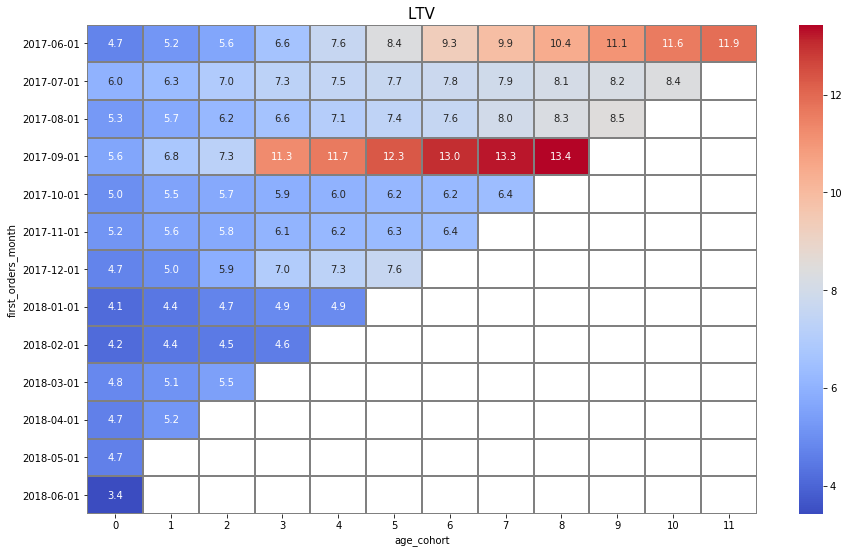

In [59]:
plt.figure(figsize=(15, 9))
plt.title('LTV',fontsize = 15)
sns.heatmap(LTV,
            annot = True,
            fmt = '.1f',
            linewidths = 1,
            linecolor = 'gray',
            cmap = 'coolwarm'
           ) 
plt.show()

In [60]:
print(f'Средний LTV за полгода - {round(LTV[5].mean(),2)}')

Средний LTV за полгода - 7.97


За полгода в среднем делают почти 8 покупок, т.е. 1-2 покупки в месяц. На тепловой карте хорошо видны когорты,в которых покупки совершаются регулярно. Это июньская и сентябрьская когорты. Пиковое значение среднего чека в декабре у сентябрьской когорты очень интересно. Возможно, люди покупали подарки, или была запущена акция макретологами. У остальных когорт показатели низкие и не превышают средних. Опять отличаются когорты начала 2018 года, LTV не превышает 5,5 

<a id='market'></a><font color='blue'>Маркетинговые метрики</font>

In [61]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [62]:
total_costs = costs['costs'].sum()
print(f'Всего на рекламу было потрачено {total_costs}')

Всего на рекламу было потрачено 329131.62


Добавлю столбец с месяцем и создам сводную таблицу для подсчета маркетинговых затрат по источникам

In [63]:
costs['month'] = costs['dt'].astype('datetime64[M]')
cost_per_sours = (costs
                  .pivot_table(index = 'month',
                             columns = 'source_id',
                             values = 'costs',
                             aggfunc='sum'))
cost_per_sours.index = cost_per_sours.index.astype('str')
cost_per_sours

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


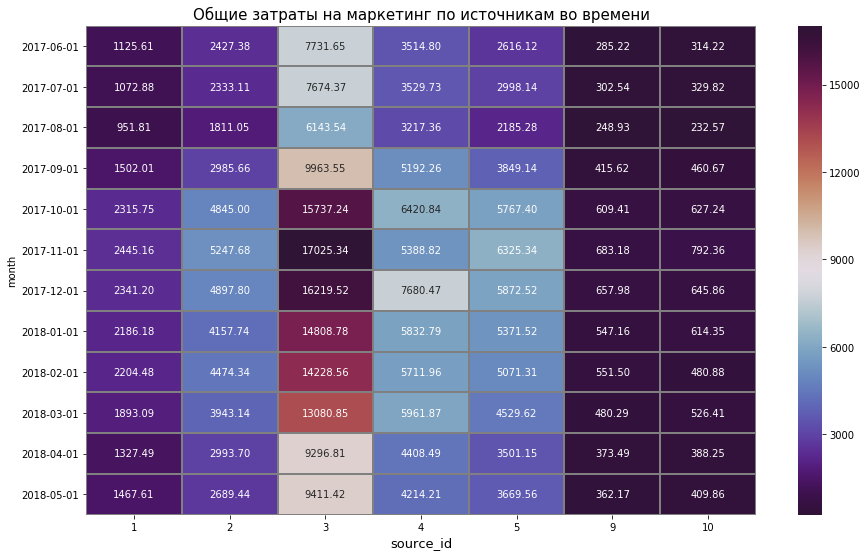

In [64]:
plt.figure(figsize=(15, 9))
plt.title('Общие затраты на маркетинг по источникам во времени', fontsize = 15)
plt.xlabel('Источники', fontsize = 13)
sns.heatmap(cost_per_sours,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray',
            cmap = 'twilight_shifted'
           ) 
plt.show()

График затрат по источникам во времени

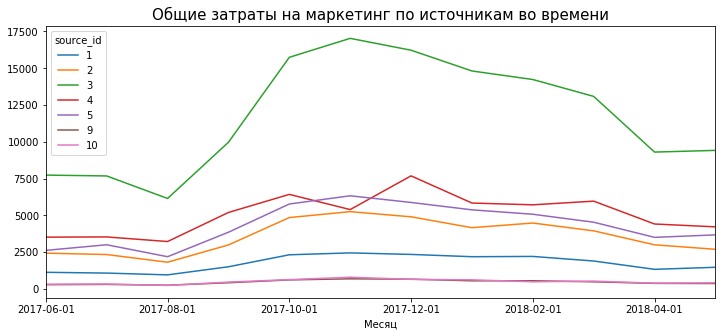

In [65]:
cost_per_sours.plot(figsize = (12,5))
                   
plt.title('Общие затраты на маркетинг по источникам во времени',fontsize = 15)
plt.xlabel('Месяц')
plt.show()

Из графика видно, что наибольшие траты были на третий источник. Начиная с сентября по апрель они превышали 10 000. В то время как траты на 9й и 10й источник очень маленькие.

<font color='green'>CAC</font>

In [66]:
visits_log.head()

,device,end_ts,source_id,start_ts,uid,month,date,day_of_week,year,visit_month_mau,visit_week_wau,lifetime,first_date,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,2017-12-20,51,2017,2017-12-01,2017-12-14,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,2018-02-19,8,2018,2018-02-01,2018-02-15,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,2017-07-01,26,2017,2017-07-01,2017-06-29,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,2018-05-20,20,2018,2018-05-01,2018-05-17,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,3,2018-03-09,10,2018,2018-03-01,2018-03-08,1680,2018-03-09 20:05:00,2018-03-01,0


Источник первого входа для каждого пользователя

In [67]:
users = visits_log.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]
users

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


In [68]:
byuers = pd.merge(byuers,users, on = 'uid')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0,5


In [69]:
byuers_daily = (byuers
                .groupby(['source_id','first_orders_day'])
                .agg({'uid':'count'})
               .reset_index())
byuers_daily.rename(columns = {'uid':'n_byuers'}, inplace = True)
byuers_daily

,source_id,first_orders_day,n_byuers
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18
...,...,...,...
2430,10,2018-05-27,2
2431,10,2018-05-28,10
2432,10,2018-05-29,7
2433,10,2018-05-30,5


In [70]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [71]:
coast_per_byuers = pd.merge(byuers_daily,costs,left_on = ['source_id','first_orders_day'], right_on = ['source_id','dt'])
coast_per_byuers.head()

,source_id,first_orders_day,n_byuers,dt,costs,month
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01


In [72]:
coast_per_byuers['coast_per_byuers'] = coast_per_byuers['costs']/coast_per_byuers['n_byuers']
coast_per_byuers.head()

,source_id,first_orders_day,n_byuers,dt,costs,month,coast_per_byuers
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01,5.371429
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01,8.892857
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01,5.218571
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01,18.333333
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01,3.171111


Сводная таблица по месяцам

In [73]:
CAC = (coast_per_byuers
       .pivot_table(index = 'month',
                   columns = 'source_id',
                   values = 'coast_per_byuers',
                   aggfunc = 'mean'))
CAC

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


График затрат на пользователя по источникам

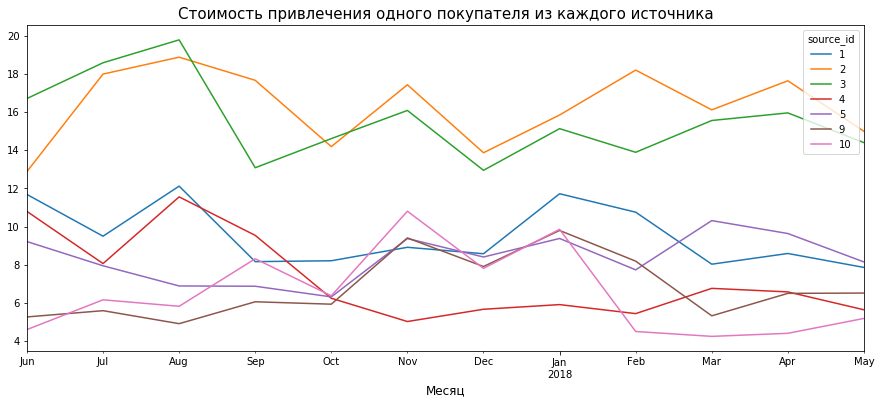

In [74]:
CAC.plot(figsize = (15,6))
plt.title('Стоимость привлечения одного покупателя из каждого источника',fontsize = 15)
plt.xlabel('Месяц',fontsize = 12)
plt.show()

Из графика видно, что стоимость привлечения пользователей высока у рекламного источника **2**. Возможно, это означает, что при высоких тратах с этого источника пришло мало пользователей. При этом стоимость привлечения по рекламному источнику **4** сильно упала. Возможно, здесь обратная ситуация, при прежних вложениях приходит больше пользователей.

Среднее САС по источнику

In [75]:
CAC_mean = coast_per_byuers.groupby('source_id')[['coast_per_byuers']].mean()
CAC_mean

,coast_per_byuers
source_id,
1,9.489732
2,16.287024
3,15.580474
4,7.271743
5,8.336731
9,6.842532
10,6.555415


Датафрейм для подсчета LTV по источнику

In [76]:
df = pd.merge(orders_log,byuers, how = 'inner', on = 'uid')
df.head()

,buy_ts,revenue,uid,orders_month,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


<font color='green'>ROMI</font>

Цикл, для подсчета LTV по источникам (буду применять цикл while, так как не в каждом источнике достаточно данных для построения когорты)

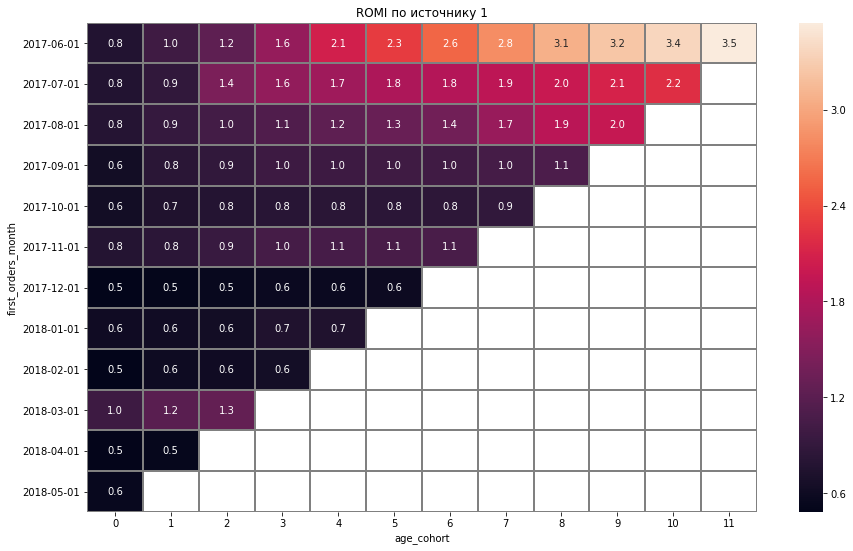

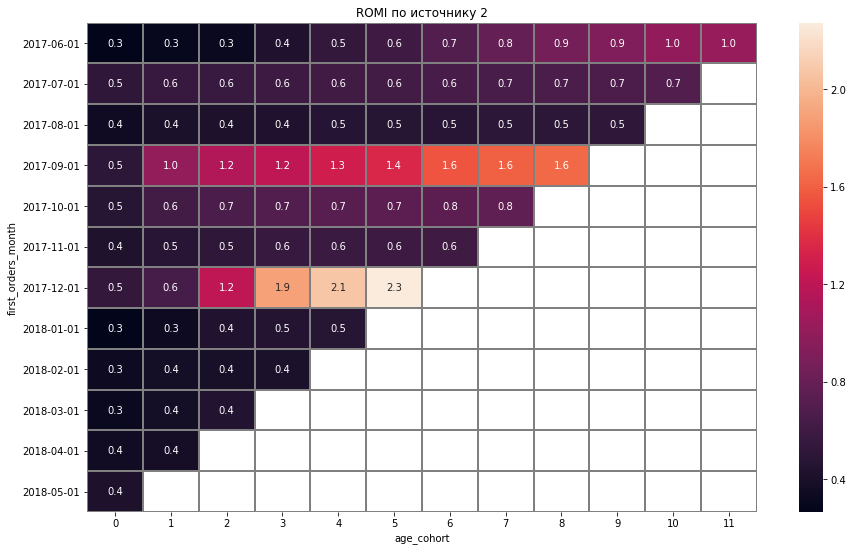

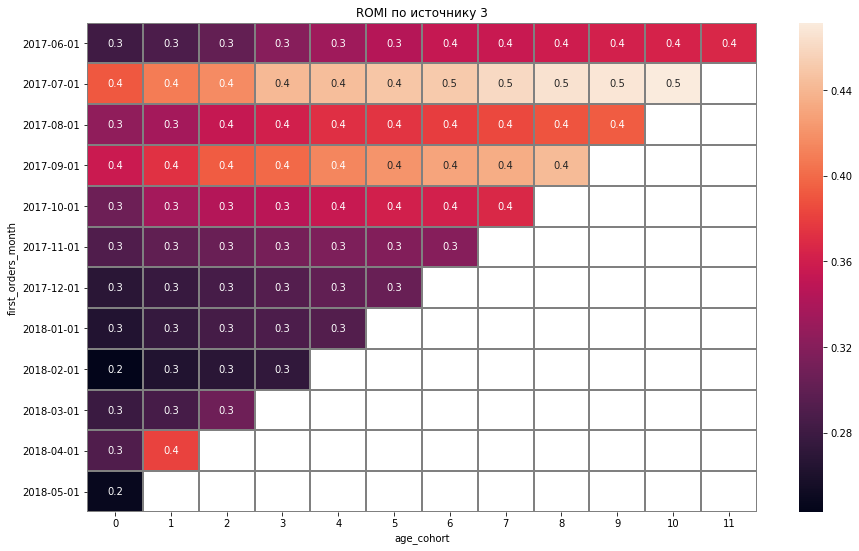

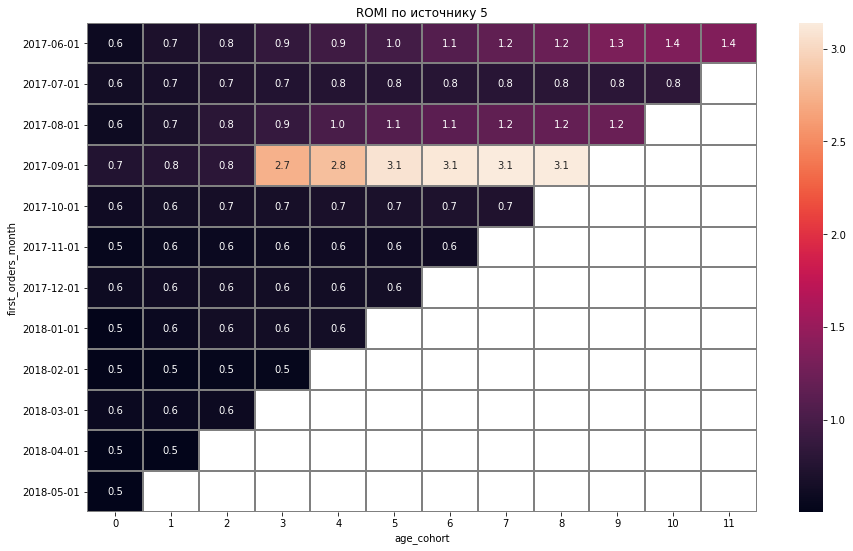

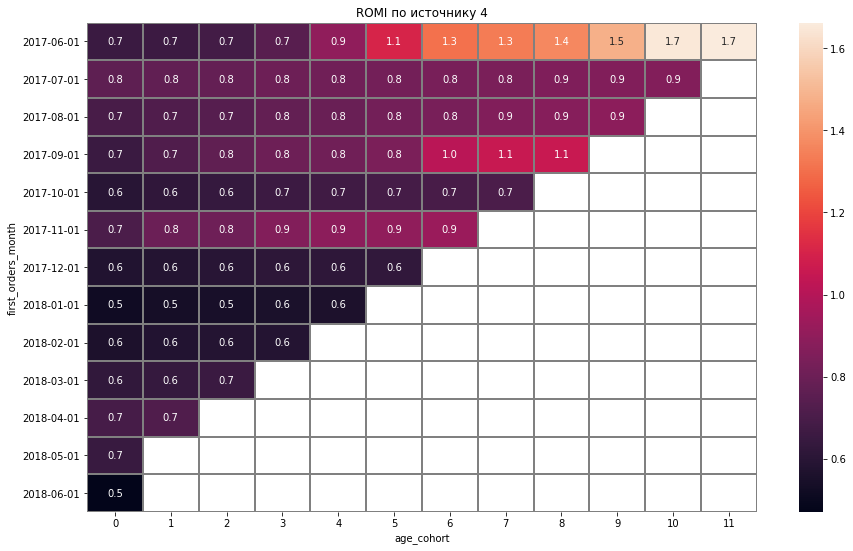

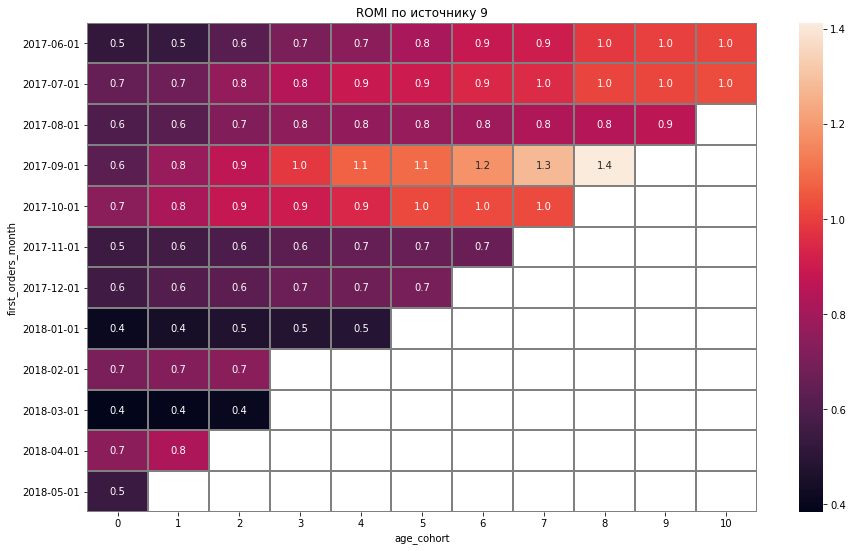

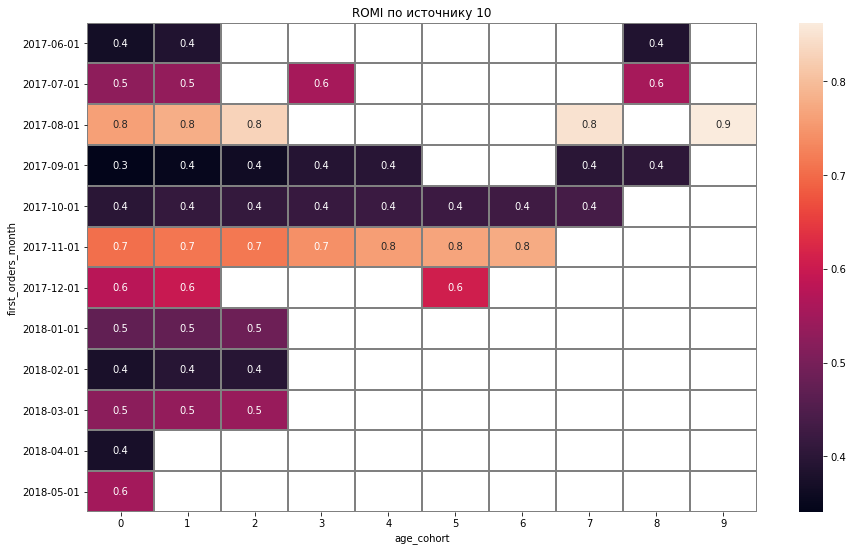

In [77]:
for value in df['source_id'].unique():
    try: 
        df_i = df[df['source_id'] == value]
        cohort_df = (df_i
              .groupby(['first_orders_month','orders_month'])
              .agg({'revenue':'sum'})
              .reset_index())
        cohort_df.rename(columns = {'revenue':'revenue_sum'}, inplace = True)
        cohort_age = df_i.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
        cohort_age.rename(columns = {'uid':'n_buyers'}, inplace = True)

        cohort_ltv = pd.merge(cohort_df,cohort_age,on = 'first_orders_month')
        cohort_ltv

        cohort_ltv['rev_per_buyers'] = cohort_ltv['revenue_sum']/cohort_ltv['n_buyers']

        cohort_ltv['age_cohort'] = (((cohort_ltv['orders_month']-cohort_ltv['first_orders_month'])/np.timedelta64(1,'M'))
                                    .round().astype('int'))
        cohort_ltv['ROMI'] = cohort_ltv['rev_per_buyers']/CAC_mean['coast_per_byuers'][value]
        cohort_ltv['first_orders_month'] = cohort_ltv['first_orders_month'].astype('str')
        ROMI = (cohort_ltv
           .pivot_table(index = 'first_orders_month',
                        columns = 'age_cohort',
                        values = 'ROMI',
                        aggfunc = 'sum')
           .cumsum(axis=1)
          )

        ROMI.round(2).fillna('') 
        plt.figure(figsize=(15, 9))
        plt.title('ROMI по источнику {}'.format(value))
        sns.heatmap(ROMI,
                annot=True,
                fmt='.1f',
                linewidths=1,
                linecolor='gray') 
        plt.show()

    except KeyError:
        pass

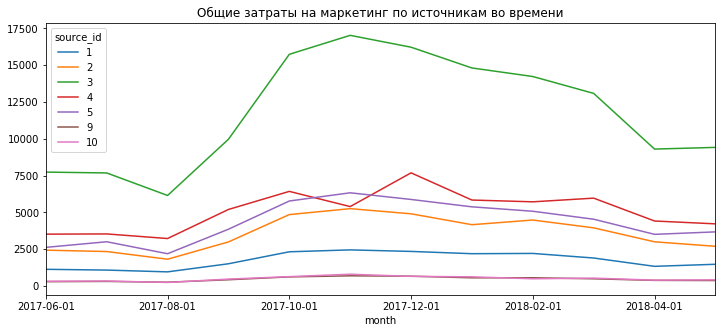

In [78]:
cost_per_sours.plot(figsize = (12,5),
                   title = 'Общие затраты на маркетинг по источникам во времени')
plt.show()

**Рекламный источник 1**

По окупаемости первый источник показывает хорошие результаты в 2017 году. Окупаемость началась со второго или третьего месяца. В мартовской когорте окупаемость стартует буквально в первый месяц. Возможно, была проведена мощная рекламная компания по этому источнику, запущенная маркетинговым отделом.

**Рекламный источник 2**

По окупаемости второй источник показал другие результаты: окупились только две когорты сентябрьская и декабрьская. Январская окупилась за год. При этом из графика маркетинговых затрат видно, что стоимость пользователя здесь высока.

**Рекламный источник 3**

Из графиков видно, что затраты на третий источник самые высокие, при этом стоимость привлечения пользователя тоже очень высока. Важно отметить, что не окупилась ни одна когорта. Я считаю, что этот источник не стоит таких вложений, лучше направить эти средства на источник, который окупается.

**Рекламный источник 4**

Затраты на четвертый источник меньше, чем на третий, но чуть больше, чем на все остальные источники.Окупились всего 2 когорты: июньская и сентябрьская. И при этом в 2018 году хорошие коэффициенты на окупаемость в будущем. Период окупаемости здесь больше чем, в первой или второй (6-7 месяцев). Но в этот источник имеет смысл вложиться.

**Рекламный источник 5**

Окупаемость в 5м источнике тоже присутствует в трех когортах: августовская, июньская и сентябрьская. При этом при одинаковых затратах на продвижение в 2017 году когорты окупились, а в 2018 показатель даже не меняется со временем. Я бы обратил внимание на то, какие акции проводились маркетингом в период с июня по сентябрь 2017. Потому что именно они принесли клиентов, которые покупают.

**Рекламный источник 9**

При невысоких затратах на привлечение по этому источнику видна окупаемость в первые полгода. Прибыль превышает затраты буквально через 4-6 месяцев стабильно. Опять же, коэффициенты не растут в 2018 году. Возможно , имеет смысл вложить средства на продвижение сюда.

**Рекламный источник 10**

По источнику 10 видимо мало данных. Тепловая карта показывает, что ни одна когорта не окупилась. Но коэффициенты близки к 1. Возможно, если бы было больше данных и при должных финансовых вливаниях,то картина была бы другой. Сейчас финансирование этого источника минимальное.

# <a id='recomend'></a><font style="background-color: Cyan; color=black">3. Рекомендации отделу маркетинга</font> #

Исследование показало, что компания финансирует рекламные источники, которые не приносят доход. Более того, они еще и занимают огромную часть выделяемых денежных средств.

Для каждого сточника я написал краткую характеристику и рекомендации, возможные пути развития этих источников.

Есть основание полагать, что достаточное и разумное финансирование доходных источников принесет большую прибыль, увеличит средний чек, и, наконец, даст рост коэфициенту возврата.